In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Real Estste Price Predictor**

Data loaded from /content/drive/MyDrive/housing.csv
Training Random Forest Model...
Training complete.

--- Regression Performance ---
Root Mean Squared Error (RMSE): $49,554.49
R2 Score: 0.8191

--- Classification (High vs Low Value) ---
Accuracy: 87.60%
Precision: 0.84


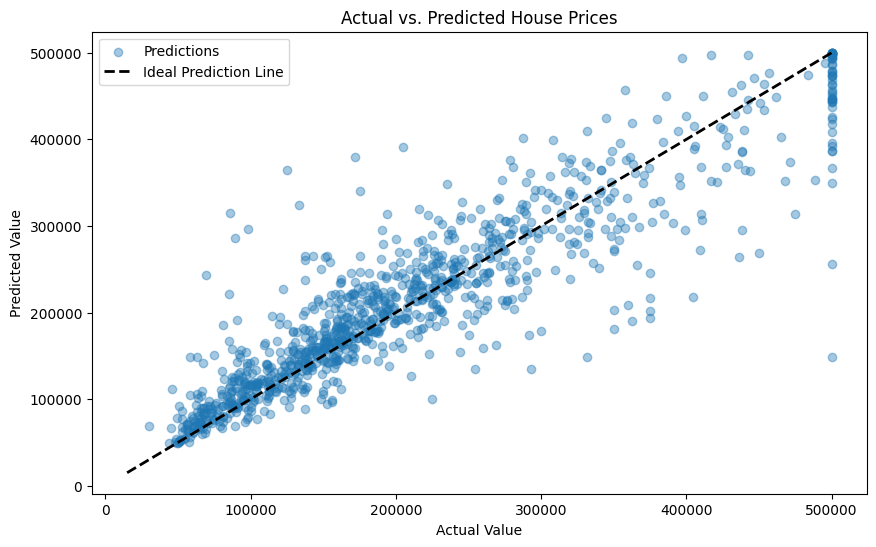


--- Running Prediction on Sample Data (No manual input required) ---
Input Location: 37.88, -122.23 (NEAR BAY)
Predicted house price: $435,960.06


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score

# --- 1. LOAD DATA (ROBUST) ---
# We attempt to load from Drive, but fall back to the public GitHub URL if not found.
file_path = '/content/drive/MyDrive/housing.csv'
github_url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Data loaded from {file_path}")
except FileNotFoundError:
    print(f"Local file not found at {file_path}.")
    print("Downloading data directly from GitHub source...")
    df = pd.read_csv(github_url)
    print("Data loaded successfully from GitHub.")

# --- 2. DATA CLEANSING ---
# Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
if initial_rows - len(df) > 0:
    print(f"Removed {initial_rows - len(df)} duplicate rows.")

# Handle missing values
median_bedrooms = df["total_bedrooms"].median()
df["total_bedrooms"] = df["total_bedrooms"].fillna(median_bedrooms)

# --- 3. FEATURE ENGINEERING ---
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

# --- 4. PREPROCESSING PIPELINE ---
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

num_attribs = list(X.select_dtypes(include=[np.number]))
cat_attribs = ["ocean_proximity"]

# FIX: Added handle_unknown='ignore' to prevent crashes if user enters a weird category
full_pipeline = ColumnTransformer([
    ("num", "passthrough", num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# --- 5. TRAIN MODEL ---
print("Training Random Forest Model...")
forest_reg = Pipeline([
    ('preprocessor', full_pipeline),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
forest_reg.fit(X_train, y_train)
print("Training complete.")

# --- 6. EVALUATION (REGRESSION) ---
predictions = forest_reg.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print("\n--- Regression Performance ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")

# --- 7. EVALUATION (CLASSIFICATION) ---
threshold = y.median()
y_test_class = (y_test > threshold).astype(int)
pred_class = (predictions > threshold).astype(int)

precision = precision_score(y_test_class, pred_class)
recall = recall_score(y_test_class, pred_class)
acc_class = accuracy_score(y_test_class, pred_class)

print(f"\n--- Classification (High vs Low Value) ---")
print(f"Accuracy: {acc_class:.2%}")
print(f"Precision: {precision:.2f}")

# --- 8. VISUALIZATION ---

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.4, label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Ideal Prediction Line')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.show()

# --- 9. USER PREDICTION FUNCTION (AUTOMATED) ---
def predict_house_price(longitude, latitude, housing_median_age, total_rooms,
                        total_bedrooms, population, households, median_income, ocean_proximity):
    """
    Takes raw input, processes it, and returns the predicted price.
    """
    input_data = pd.DataFrame({
        'longitude': [longitude],
        'latitude': [latitude],
        'housing_median_age': [housing_median_age],
        'total_rooms': [total_rooms],
        'total_bedrooms': [total_bedrooms],
        'population': [population],
        'households': [households],
        'median_income': [median_income],
        'ocean_proximity': [ocean_proximity]
    })

    # Apply Feature Engineering
    input_data["rooms_per_household"] = input_data["total_rooms"] / input_data["households"]
    input_data["bedrooms_per_room"] = input_data["total_bedrooms"] / input_data["total_rooms"]
    input_data["population_per_household"] = input_data["population"] / input_data["households"]

    prediction = forest_reg.predict(input_data)
    return prediction[0]

print("\n--- Running Prediction on Sample Data (No manual input required) ---")

# Sample data (Based on a typical 'Near Bay' home in the dataset)
sample_longitude = -122.23
sample_latitude = 37.88
sample_age = 41.0
sample_rooms = 880
sample_bedrooms = 129
sample_population = 322
sample_households = 126
sample_income = 8.3252
sample_ocean = "NEAR BAY"

# Call the function
predicted_price = predict_house_price(
    sample_longitude, sample_latitude, sample_age, sample_rooms,
    sample_bedrooms, sample_population, sample_households,
    sample_income, sample_ocean
)

print(f"Input Location: {sample_latitude}, {sample_longitude} ({sample_ocean})")
print(f"Predicted house price: ${predicted_price:,.2f}")

housing.csv loaded successfully.


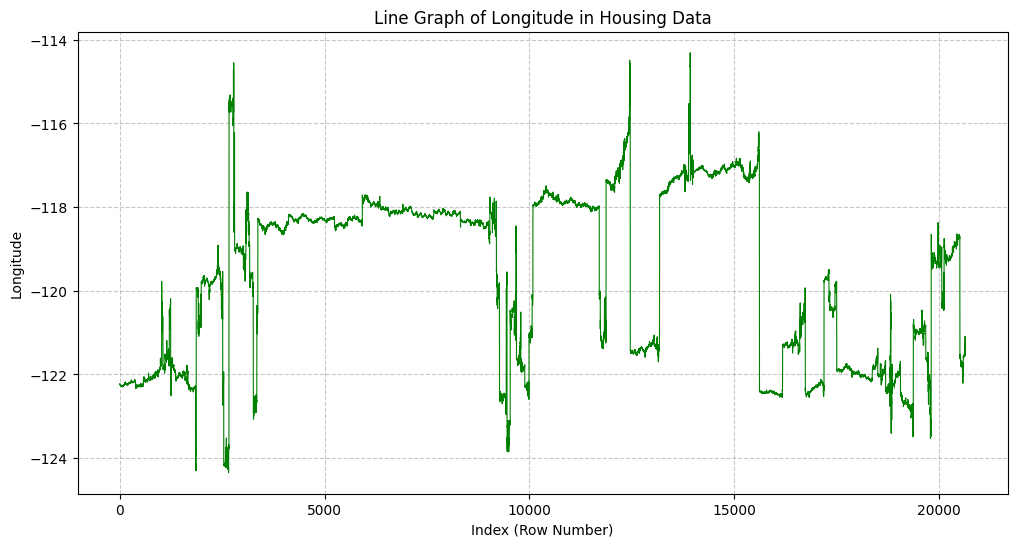

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    # Exit or handle the error appropriately if the file is not found
    raise

# Create a line graph for 'longitude'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['longitude'], linewidth=0.8, color='green')
plt.title('Line Graph of Longitude in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Longitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


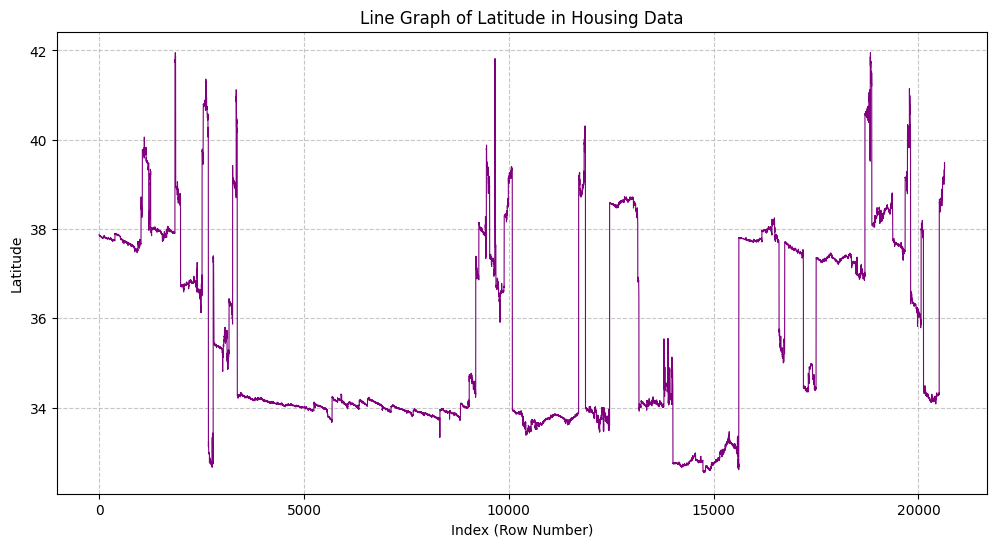

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'latitude'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['latitude'], linewidth=0.8, color='purple')
plt.title('Line Graph of Latitude in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


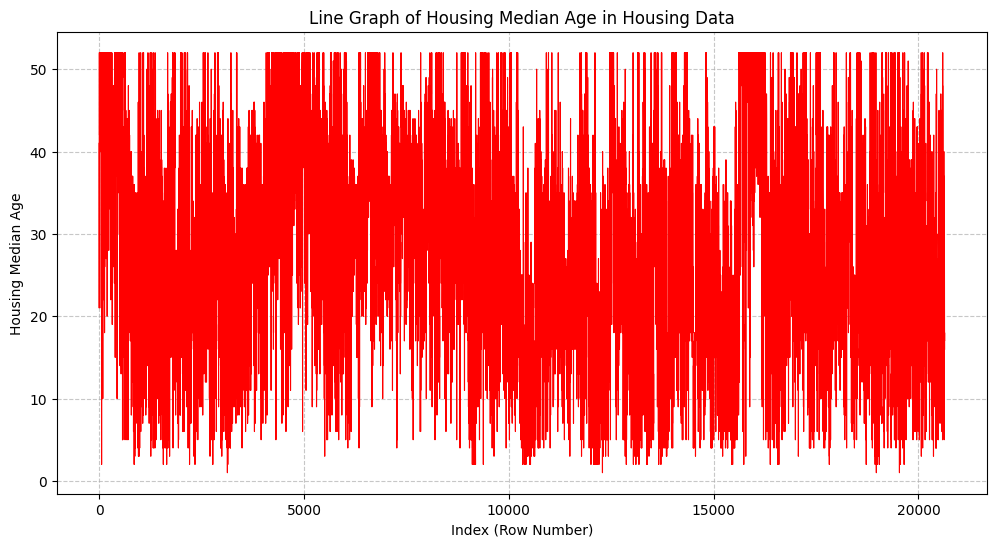

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'housing_median_age'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['housing_median_age'], linewidth=0.8, color='red')
plt.title('Line Graph of Housing Median Age in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Housing Median Age')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


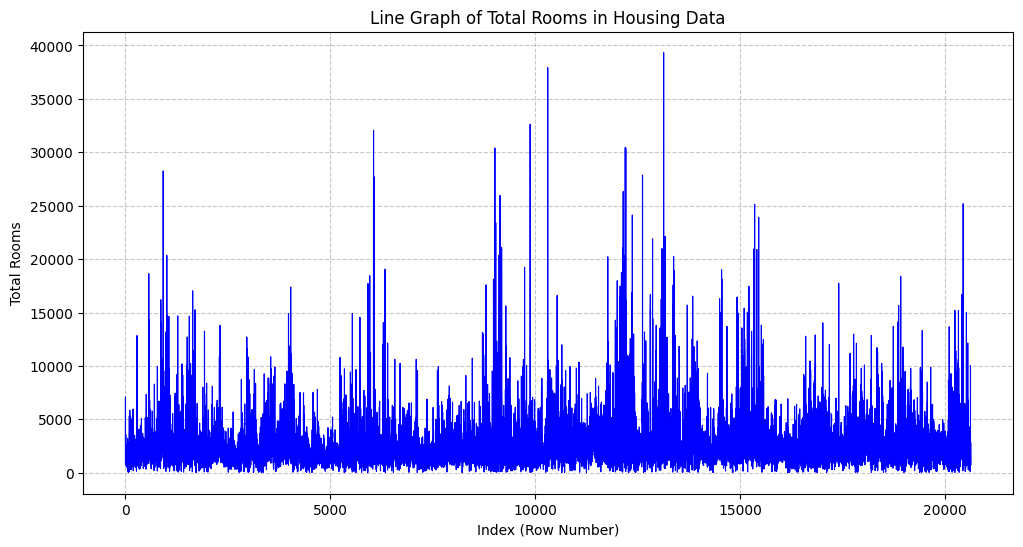

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'total_rooms'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['total_rooms'], linewidth=0.8, color='blue')
plt.title('Line Graph of Total Rooms in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Total Rooms')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


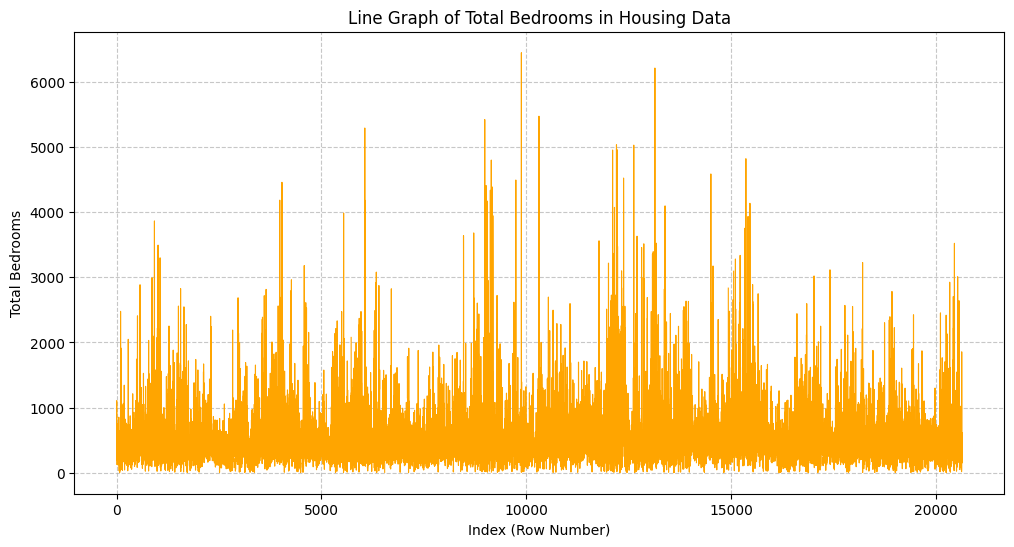

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'total_bedrooms'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['total_bedrooms'], linewidth=0.8, color='orange')
plt.title('Line Graph of Total Bedrooms in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Total Bedrooms')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


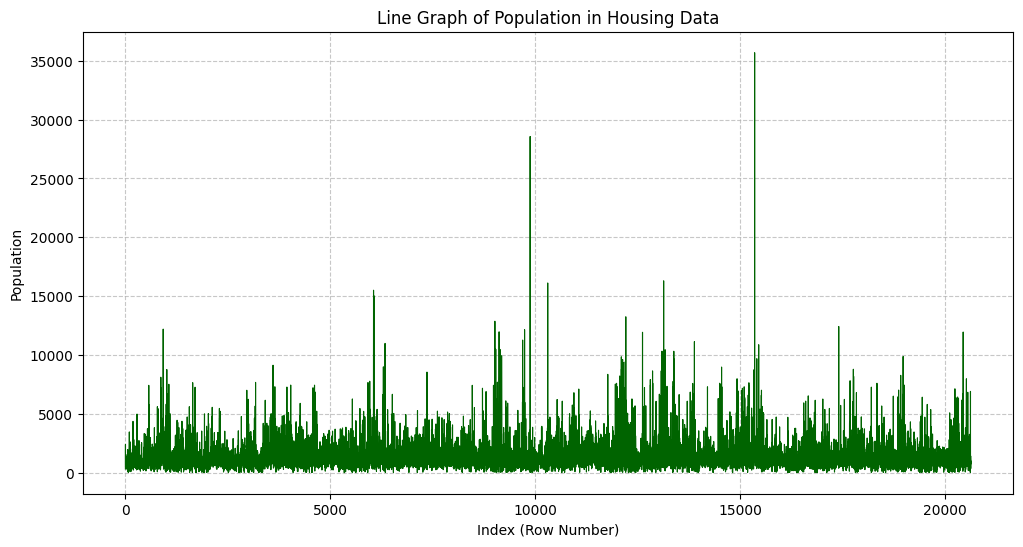

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'population'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['population'], linewidth=0.8, color='darkgreen')
plt.title('Line Graph of Population in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Population')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


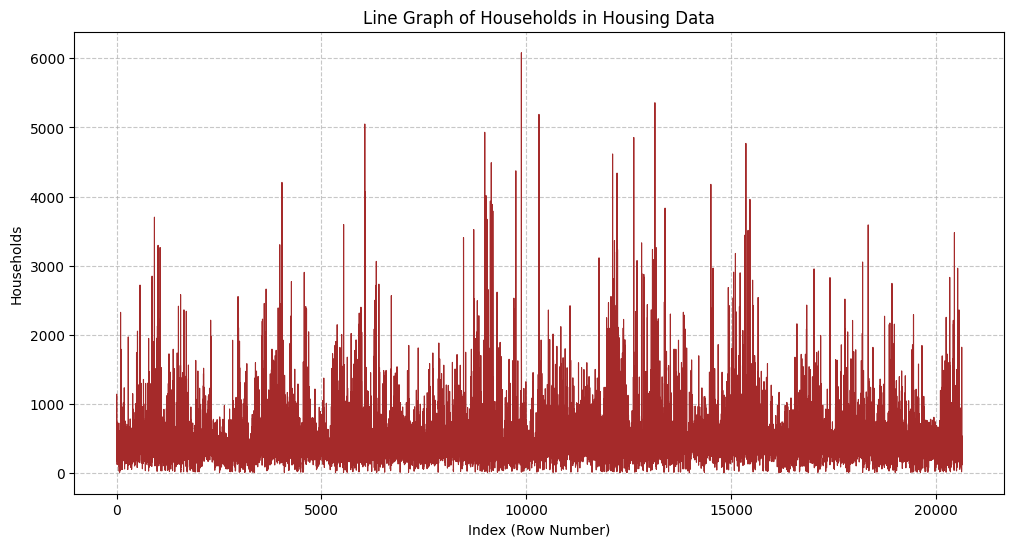

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'households'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['households'], linewidth=0.8, color='brown')
plt.title('Line Graph of Households in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Households')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


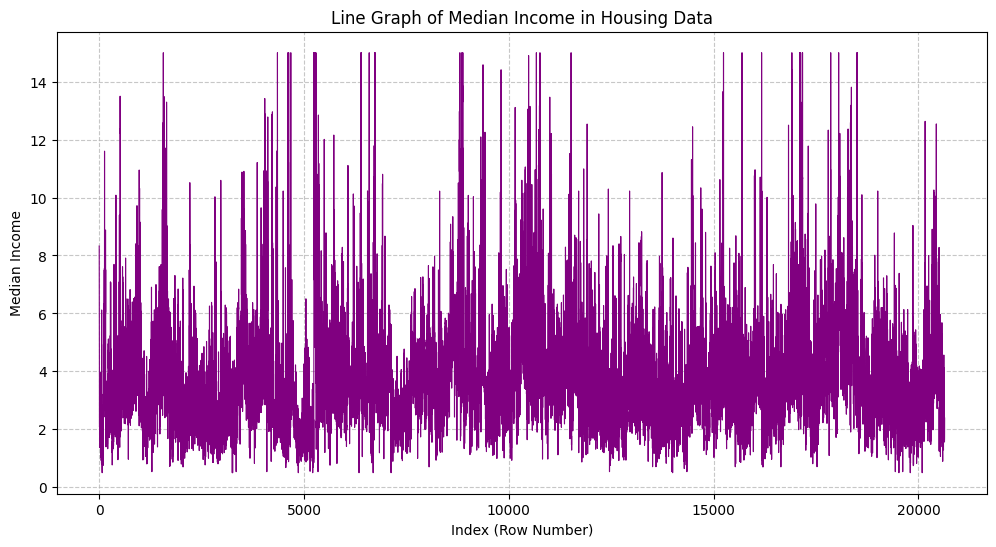

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'median_income'
plt.figure(figsize=(12, 6))
plt.plot(df_housing['median_income'], linewidth=0.8, color='purple')
plt.title('Line Graph of Median Income in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Median Income')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

housing.csv loaded successfully.


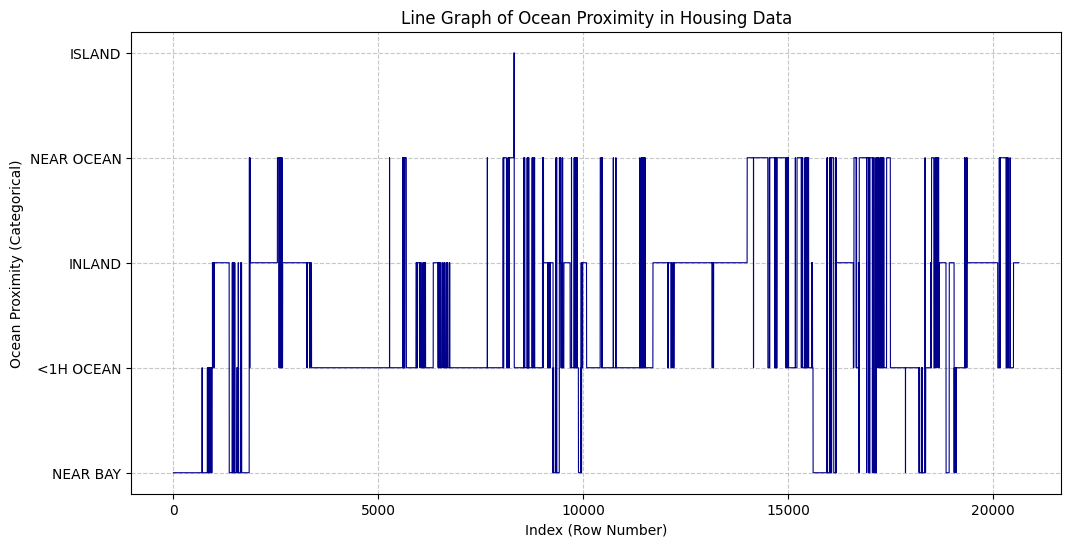

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the path to your housing.csv is correctly defined
# Based on previous interactions, it's in '/content/drive/MyDrive'
path = '/content/drive/MyDrive'

try:
    df_housing = pd.read_csv(f'{path}/housing.csv')
    print("housing.csv loaded successfully.")
except FileNotFoundError:
    print(f"Error: 'housing.csv' not found at {path}. Please check the path and filename.")
    raise

# Create a line graph for 'ocean_proximity'
# Note: Plotting a categorical variable with plt.plot will assign numerical values
# to categories and connect them with lines. A bar plot or count plot might be
# more appropriate for visualizing the distribution of categorical data.
plt.figure(figsize=(12, 6))
plt.plot(df_housing['ocean_proximity'], linewidth=0.8, color='darkblue')
plt.title('Line Graph of Ocean Proximity in Housing Data')
plt.xlabel('Index (Row Number)')
plt.ylabel('Ocean Proximity (Categorical)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()